# Set up 

In [7]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

In [8]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/omitted_data/')

## Perturbing enzymes

In [9]:
ant ='../../../models/Antimony/TopologyB-reg2.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.815104431273357e-15

In [10]:
pt_levels = [0.1, 0.2, 0.3, 0.4,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [11]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out external metabolite data

In [12]:
data01 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_0.1.csv')[fluxes+internal+enzymes]
data02 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_0.2.csv')[fluxes+internal+enzymes]
data03 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_0.3.csv')[fluxes+internal+enzymes]
data04 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_0.4.csv')[fluxes+internal+enzymes]
data05 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_0.5.csv')[fluxes+internal+enzymes]

data15 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_1.5.csv')[fluxes+internal+enzymes]
data3 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_3.csv')[fluxes+internal+enzymes]
data5 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_5.csv')[fluxes+internal+enzymes]
data7 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_7.csv')[fluxes+internal+enzymes]
data100 = pd.read_csv('../../../data/generated_data/TopologyB-reg2/TopologyB-reg2_10.csv')[fluxes+internal+enzymes]


In [13]:
BMCA_obj01 = antemll.antemll(ant, data01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


## Running ADVI

In [14]:
def run_BayesInf(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)



    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in data100.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.yn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 20000

        advi = pm.ADVI(random_seed=1)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-2), 
            total_grad_norm_constraint=1,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 12,125


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 6,149.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,354.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,690.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 604.77


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = -338.43


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,986.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 18,730


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 40,567


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 88,844


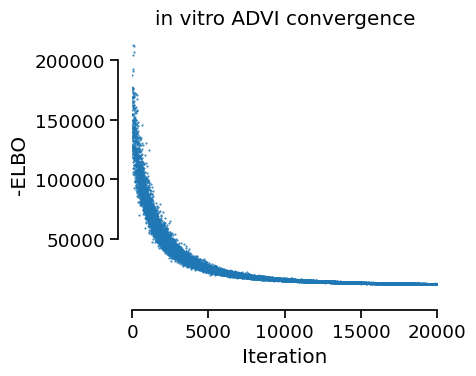

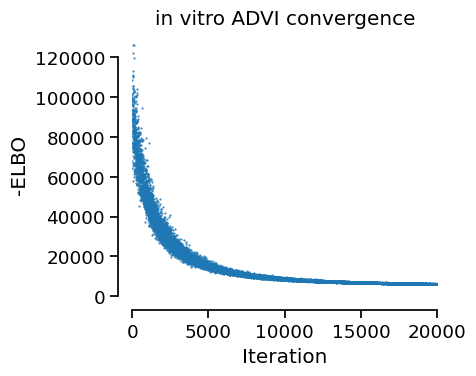

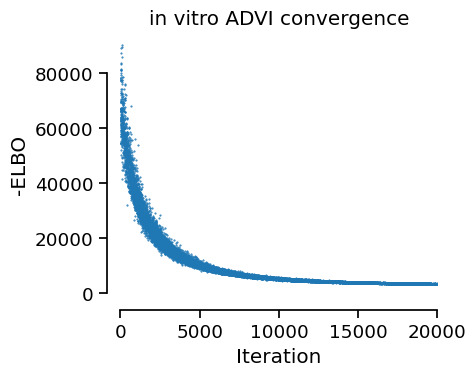

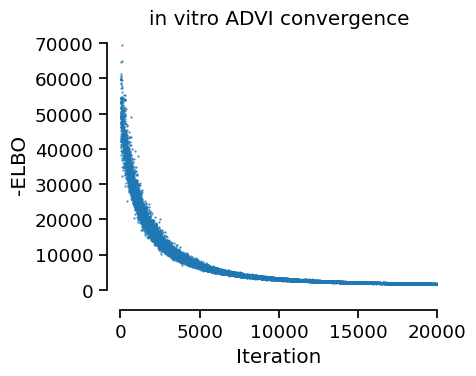

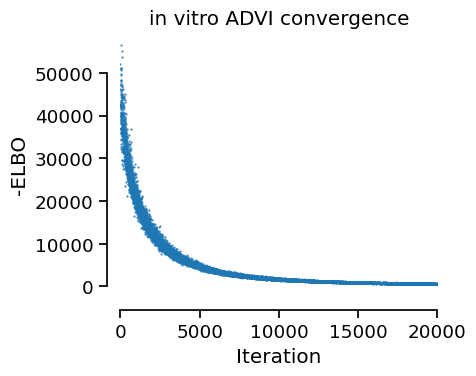

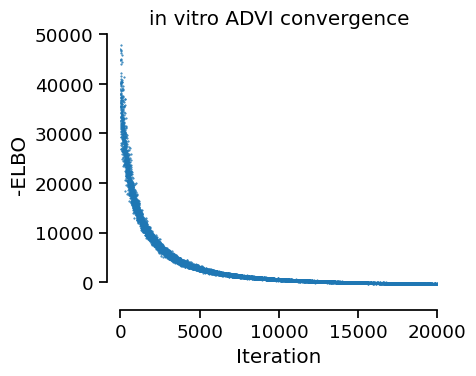

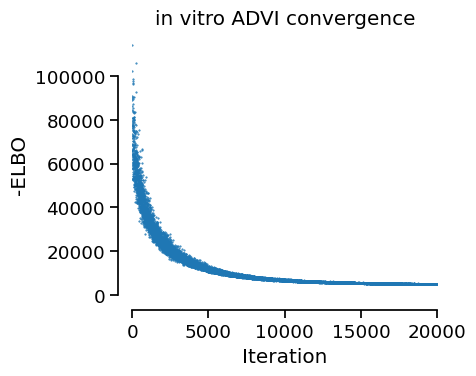

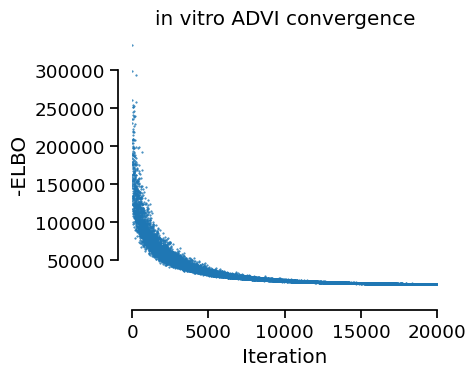

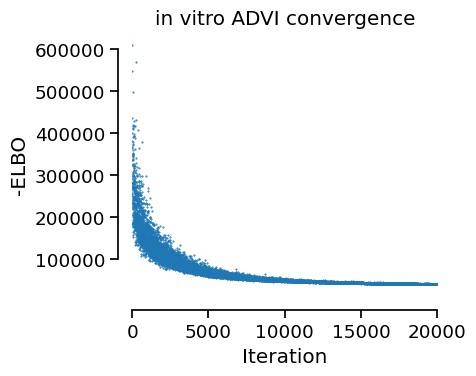

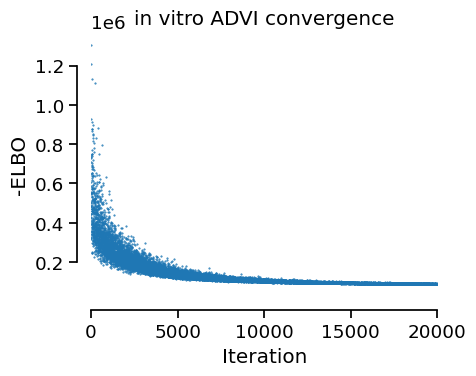

In [15]:
trace01 = run_BayesInf(BMCA_obj01, n_samp=3)
trace02 = run_BayesInf(BMCA_obj02, n_samp=3)
trace03 = run_BayesInf(BMCA_obj03, n_samp=3)
trace04 = run_BayesInf(BMCA_obj04, n_samp=3)
trace05 = run_BayesInf(BMCA_obj05, n_samp=3)

trace15 = run_BayesInf(BMCA_obj15, n_samp=3)
trace3 = run_BayesInf(BMCA_obj3, n_samp=3)
trace5 = run_BayesInf(BMCA_obj5, n_samp=3)
trace7 = run_BayesInf(BMCA_obj7, n_samp=3)
trace100 = run_BayesInf(BMCA_obj100, n_samp=3)

### saving trace data

In [16]:
with gzip.open("topologyB-reg2_omitExMet_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [18]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-reg2_omitExMet_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [19]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check 

In [20]:
med_Ex01_advi = util.get_az_mean(trace01)
med_Ex02_advi = util.get_az_mean(trace02)
med_Ex03_advi = util.get_az_mean(trace03)
med_Ex04_advi = util.get_az_mean(trace04)
med_Ex05_advi = util.get_az_mean(trace05)

med_Ex15_advi = util.get_az_mean(trace15)
med_Ex3_advi = util.get_az_mean(trace3)
med_Ex5_advi = util.get_az_mean(trace5)
med_Ex7_advi = util.get_az_mean(trace7)
med_Ex100_advi = util.get_az_mean(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [21]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                med_Ex01_advi, med_Ex02_advi, med_Ex03_advi, 
                               med_Ex04_advi, med_Ex05_advi,  
                               med_Ex15_advi, med_Ex3_advi, med_Ex5_advi, 
                               med_Ex7_advi, med_Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg2_omitFluxes_elasticities.csv')

In [22]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

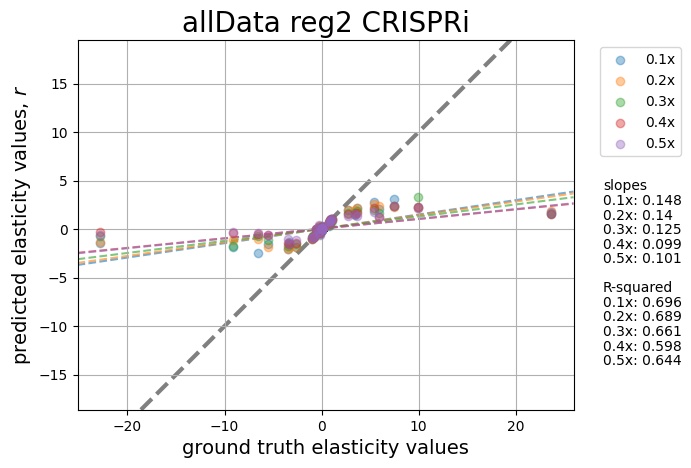

In [23]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)

plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData reg2 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 29
line_spacing = 1.5
slope_start = 4
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)



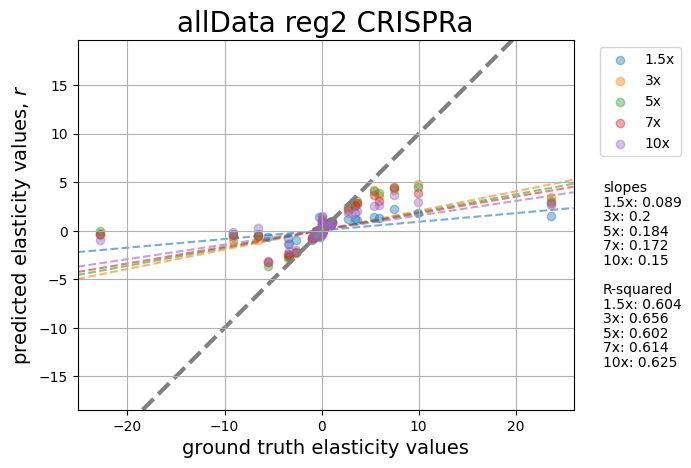

In [24]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData reg2 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 29
line_spacing = 1.5
slope_start = 4
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[5:]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+5]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[5:]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+5]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+5]), slope=e_slopes[i+5], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

In [25]:
# running ANOVA on differences btw gt and predicted
# elasticities_df = elasticities_df.sub(elasticities_df['gt'], axis=0)
stats.f_oneway(elasticities_df['0.1x'],
                elasticities_df['0.2x'],
                elasticities_df['0.3x'],
                elasticities_df['0.4x'],
                elasticities_df['0.5x'],
                elasticities_df['1.5x'],
                elasticities_df['3x'],
                elasticities_df['5x'],
                elasticities_df['7x'],
                elasticities_df['10x'])

F_onewayResult(statistic=0.3398943032511211, pvalue=0.9618068279090048)

In [26]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt      0.000000
0.1x    0.374816
0.2x    0.375563
0.3x    0.388557
0.4x    0.405782
0.5x    0.410317
1.5x    0.422964
3x      0.322451
5x      0.335941
7x      0.368736
10x     0.428189
dtype: float64

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

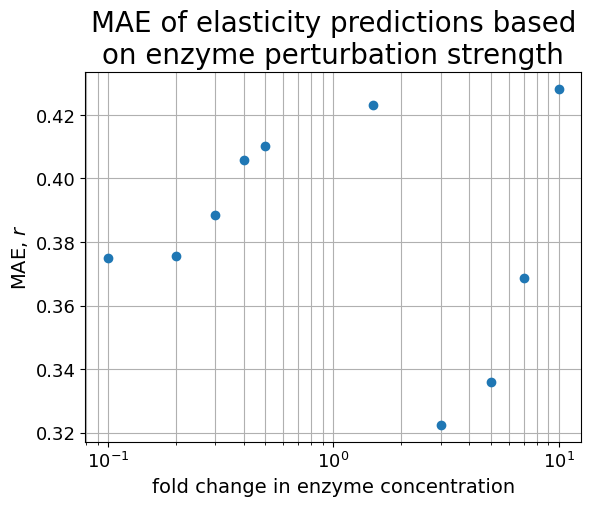

In [27]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

In [28]:
MAE.to_csv('../../../data/results/MAE/topologyB-reg2_omitExMet_MAE.csv')

## Calculating FCCs

In [29]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [30]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [31]:
priorFCC01 = util.estimate_CCs(BMCA_obj01, Ex01_prior.reshape((19,13)))
priorFCC02 = util.estimate_CCs(BMCA_obj02, Ex02_prior.reshape((19,13)))
priorFCC03 = util.estimate_CCs(BMCA_obj03, Ex03_prior.reshape((19,13)))
priorFCC04 = util.estimate_CCs(BMCA_obj04, Ex04_prior.reshape((19,13)))
priorFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_prior.reshape((19,13)))

priorFCC15 = util.estimate_CCs(BMCA_obj15, Ex15_prior.reshape((19,13)))
priorFCC3 = util.estimate_CCs(BMCA_obj3, Ex3_prior.reshape((19,13)))
priorFCC5 = util.estimate_CCs(BMCA_obj5, Ex5_prior.reshape((19,13)))
priorFCC7 = util.estimate_CCs(BMCA_obj7, Ex7_prior.reshape((19,13)))
priorFCC100 = util.estimate_CCs(BMCA_obj100, Ex100_prior.reshape((19,13)))


In [32]:
postFCC01 = util.estimate_CCs(BMCA_obj01, med_Ex01_advi.reshape((19,13)))
postFCC02 = util.estimate_CCs(BMCA_obj02, med_Ex02_advi.reshape((19,13)))
postFCC03 = util.estimate_CCs(BMCA_obj03, med_Ex03_advi.reshape((19,13)))
postFCC04 = util.estimate_CCs(BMCA_obj04, med_Ex04_advi.reshape((19,13)))
postFCC05 = util.estimate_CCs(BMCA_obj05, med_Ex05_advi.reshape((19,13)))

postFCC15 = util.estimate_CCs(BMCA_obj15, med_Ex15_advi.reshape((19,13)))
postFCC3 = util.estimate_CCs(BMCA_obj3, med_Ex3_advi.reshape((19,13)))
postFCC5 = util.estimate_CCs(BMCA_obj5, med_Ex5_advi.reshape((19,13)))
postFCC7 = util.estimate_CCs(BMCA_obj7, med_Ex7_advi.reshape((19,13)))
postFCC100 = util.estimate_CCs(BMCA_obj100, med_Ex100_advi.reshape((19,13)))

In [33]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


## Evaluating FCC ranking

In [34]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v19']

### via Spearman rank coefficients

In [35]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [36]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]

In [37]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x-prior,0.174407,4.888387e-01,-0.394087,0.648284
0.2x-prior,0.201238,4.232877e-01,-0.366227,0.650088
0.3x-prior,0.201238,4.232877e-01,-0.357081,0.693119
0.4x-prior,0.182663,4.681613e-01,-0.357567,0.736525
0.5x-prior,0.205366,4.136354e-01,-0.356852,0.680257
1.5x-prior,0.131063,6.041941e-01,-0.430681,0.654133
3x-prior,0.131063,6.041941e-01,-0.453616,0.687901
5x-prior,0.157895,5.314833e-01,-0.392471,0.686137
7x-prior,0.120743,6.331874e-01,-0.438802,0.708437
10x-prior,0.166151,5.099505e-01,-0.405821,0.733826


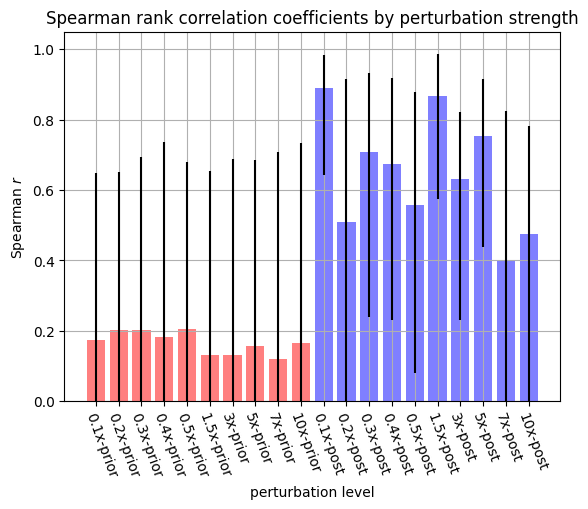

In [44]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, val in enumerate(spearman_df['r']):
    if round(val, 2) <= 0: 
        c ='gray'
    else: 
        c='k'
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color=c)

for i, val in enumerate(spearman_df['r']):
    if round(val, 2) <= 0: 
        plt.annotate(round(val, 2), (pt_labels[i], 0.02), size=8, ha='center', rotation=30,rotation_mode="anchor")

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

In [39]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyB-reg2_omitExMet_spr.csv')

### evaluating top 10 rankings

In [40]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,...,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
v19,,,,,,,,,,,,,,,,,,,,,
1.0,v18,v18,v18,v18,v18,v18,v18,v18,v18,v18,...,v18,v1,v18,v18,v18,v18,v1,v1,v1,v1
2.0,v1,v8,v8,v14,v14,v14,v15,v15,v15,v15,...,v1,v7,v1,v1,v14,v1,v7,v7,v7,v7
3.0,v7,v17,v14,v8,v16,v8,v16,v17,v17,v17,...,v7,v3,v7,v14,v8,v7,v3,v5,v5,v4
4.0,v14,v14,v17,v17,v17,v17,v17,v16,v16,v16,...,v14,v4,v14,v7,v13,v14,v12,v4,v4,v15
5.0,v5,v16,v16,v16,v8,v16,v14,v14,v14,v14,...,v8,v12,v3,v8,v1,v5,v4,v3,v3,v5
6.0,v4,v13,v13,v13,v13,v13,v8,v5,v5,v5,...,v13,v5,v12,v3,v5,v4,v5,v12,v17,v3
7.0,v9,v4,v15,v15,v15,v15,v5,v1,v1,v6,...,v4,v8,v4,v12,v3,v8,v18,v18,v9,v17
8.0,v3,v15,v4,v4,v4,v4,v4,v4,v4,v4,...,v3,v9,v8,v13,v9,v15,v14,v9,v14,v9
9.0,v8,v7,v1,v1,v1,v1,v1,v6,v6,v1,...,v9,v13,v11,v11,v12,v9,v2,v14,v12,v18


In [41]:
q.to_csv('../../../data/results/rankings/topologyB-reg2_omitExMet_rankings.csv')
rank_df = pd.read_csv('../../../data/results/rankings/topologyB-reg2_omitExMet_rankings.csv')

In [42]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,10x-prior,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
0,6,6,6,6,6,7,6,6,6,6,9,8,9,8,8,8,8,9,8,8


In [43]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([11, 13], dtype='int64')
Int64Index([11, 14], dtype='int64')
Int64Index([11, 14], dtype='int64')
Int64Index([13, 16], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([16, 17], dtype='int64')
Int64Index([14, 17], dtype='int64')
